In [4]:
# Importing necessary libraries
import os            
import shutil        
import random        
from pathlib import Path  

# Defining the source directory and the destination directory 
SOURCE_DIR = 'C:/Users/ASUS/Downloads/PCOS/PCOS'
DEST_DIR = 'C:/Users/ASUS/Downloads/PCOS/org'
TRAIN_SPLIT = 0.8  # 80% of data will be used for training, 20% for testing

# Mapping original folder names to new standardized class names
class_map = {
    'infected': 'pcos',
    'noninfected': 'normal'
}

# Creating directories for training and testing sets for each class
for phase in ['train', 'test']:
    for class_name in class_map.values():
        Path(f"{DEST_DIR}/{phase}/{class_name}").mkdir(parents=True, exist_ok=True)

# Loop through each class in the source directory
for original_class, new_class in class_map.items():
    # Get the list of all images in the current class folder
    images = os.listdir(os.path.join(SOURCE_DIR, original_class))
    random.shuffle(images)  # Shuffle images for random split

    # Calculate index to split into training and testing
    split_idx = int(len(images) * TRAIN_SPLIT)
    train_imgs = images[:split_idx]  # 80% for training
    test_imgs = images[split_idx:]   # 20% for testing

    # Copy training images to the corresponding destination folder
    for img in train_imgs:
        src = os.path.join(SOURCE_DIR, original_class, img)
        dst = os.path.join(DEST_DIR, 'train', new_class, img)
        shutil.copy2(src, dst)  # Copy with metadata

    # Copy testing images to the corresponding destination folder
    for img in test_imgs:
        src = os.path.join(SOURCE_DIR, original_class, img)
        dst = os.path.join(DEST_DIR, 'test', new_class, img)
        shutil.copy2(src, dst)

# Print confirmation message after processing
print("Dataset has been split and copied to 'data/train/' and 'data/test/' folders.")


Dataset has been split and copied to 'data/train/' and 'data/test/' folders.


In [6]:
import os

# Setting the base directory where the organized dataset is stored
base_dir = 'C:/Users/ASUS/Downloads/PCOS/org' 

# Loop through both training and testing datasets
for split in ['train', 'test']:
    print(f"\n{split.upper()} SET")  

    # Construct the full path to the current split directory
    split_path = os.path.join(base_dir, split)
    total = 0  

    # Loop through each class directory (e.g., 'pcos', 'normal') inside the split directory
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        # Ensure it's a directory (to skip any non-folder files)
        if os.path.isdir(class_path):
            count = len([img for img in os.listdir(class_path) 
                         if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{class_name}: {count} images")
            total += count 

    # Print the total number of images in the split (train/test)
    print(f"Total {split} images: {total}")



TRAIN SET
normal: 4000 images
pcos: 5427 images
Total train images: 9427

TEST SET
normal: 1000 images
pcos: 1357 images
Total test images: 2357


In [7]:
# Importing necessary libraries
import cv2                     # For image processing (OpenCV)
import numpy as np             # For array operations
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation and loading

# Function to preprocess ultrasound images
def preprocess_ultrasound(image):
    # Convert grayscale to RGB if image is grayscale (1 channel or 2D array)
    if image.shape[-1] == 1 or len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # If already RGB, convert to grayscale and back to RGB to standardize
    elif image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Resize to 224x224 (common input size for CNN models like VGG/ResNet)
    image = cv2.resize(image, (224, 224))

    # Apply median blur to reduce noise
    image = cv2.medianBlur(image, 5)

    # Normalize pixel values to [0, 1]
    image = image.astype('float32') / 255.0

    return image

# A simple wrapper for the preprocessing function (in case future logic is needed)
def preprocessing_wrapper(image):
    image = preprocess_ultrasound(image)
    return image

# Define data augmentation strategy for the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_ultrasound,  # Apply custom preprocessing
    rotation_range=10,        # Random rotation up to 10 degrees
    zoom_range=0.1,           # Random zoom within range
    horizontal_flip=True      # Random horizontal flip
)

# Data generator for the test data (only preprocessing, no augmentation)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_ultrasound
)

# Paths to training and testing image directories
train_dir = 'C:/Users/ASUS/Downloads/PCOS/org/train'
test_dir = 'C:/Users/ASUS/Downloads/PCOS/org/test'

# Load training images from directory with preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),   # Resize all images to 224x224
    color_mode='rgb',         # Force all images to RGB format
    batch_size=32,            # Load 32 images at a time
    class_mode='binary',      # For binary classification (e.g., PCOS vs Normal)
    shuffle=True              # Shuffle the dataset for training
)

# Load testing images from directory with only preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),   # Resize images
    color_mode='rgb',         # RGB format
    batch_size=32,            # 32 images per batch
    class_mode='binary',      # Binary labels
    shuffle=False             # Do not shuffle, for evaluation consistency
)


Found 9427 images belonging to 2 classes.
Found 2357 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input layer for 224x224 RGB images
input_layer = Input(shape=(224, 224, 3))

# Load MobileNetV2 without top layer, with pretrained ImageNet weights
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)

# Freeze base model layers
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dropout(0.3)(x)              # Dropout for regularization
output_layer = Dense(1, activation='sigmoid')(x)  # Binary output

# Create and compile model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25040\3207661550.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Train the model for 10 epochs using training and validation data
model.fit(
    train_generator,             
    validation_data=test_generator,  
    epochs=10                    
)

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.6568 - loss: 0.6419 - val_accuracy: 0.8511 - val_loss: 0.3838
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 293s 993ms/step - accuracy: 0.8334 - loss: 0.3788 - val_accuracy: 0.9147 - val_loss: 0.2762
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 293s 991ms/step - accuracy: 0.8906 - loss: 0.2861 - val_accuracy: 0.9406 - val_loss: 0.2291
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 291s 988ms/step - accuracy: 0.9123 - loss: 0.2408 - val_accuracy: 0.9431 - val_loss: 0.1992
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 293s 993ms/step - accuracy: 0.9158 - loss: 0.2150 - val_accuracy: 0.9482 - val_loss: 0.1799
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 290s 983ms/step - accuracy: 0.9251 - loss: 0.2025 - val_accuracy: 0.9516 - val_loss: 0.1640
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 287s 974ms/step - accuracy: 0.9288 - loss: 0.1848 - val_accuracy: 0.9550 - val_loss: 0.1547
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 291s 987ms/step - accuracy: 0.9334 - lo

In [9]:
"""test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
"""
model.save('C:/Users/ASUS/Downloads/PCOS/pcos_mobilenetv2_model.h5')
print("Model saved as pcos_mobilenetv2_model.h5")
 

74/74 ━━━━━━━━━━━━━━━━━━━━ 32s 429ms/step - accuracy: 0.9396 - loss: 0.1710


Test Loss: 0.1326
Test Accuracy: 0.9601
Model saved as pcos_mobilenetv2_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 436ms/step - accuracy: 0.9396 - loss: 0.1710
Test Loss: 0.1326
Test Accuracy: 0.9601
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step


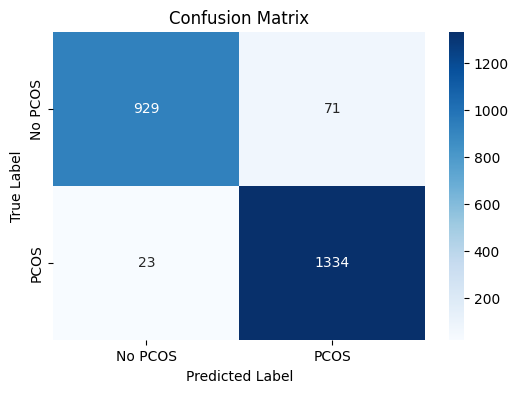


Classification Report:

              precision    recall  f1-score   support

     No PCOS       0.98      0.93      0.95      1000
        PCOS       0.95      0.98      0.97      1357

    accuracy                           0.96      2357
   macro avg       0.96      0.96      0.96      2357
weighted avg       0.96      0.96      0.96      2357



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and convert to binary predictions
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# Get true labels from the test generator
true_classes = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No PCOS", "PCOS"],
            yticklabels=["No PCOS", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report with precision, recall, f1-score
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=["No PCOS", "PCOS"]))


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_626']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


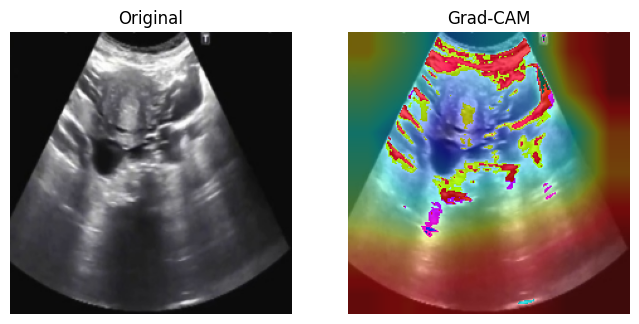

In [11]:
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image for model input
def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)      # Load image
    array = image.img_to_array(img)                       # Convert to array
    array = np.expand_dims(array, axis=0)                 # Add batch dimension
    array = array / 255.0                                 # Normalize
    return array, img

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that outputs both conv layer and prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])        # Get predicted class
        class_channel = predictions[:, pred_index]        # Focus on predicted class

    grads = tape.gradient(class_channel, conv_outputs)     # Gradients of conv layer

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))   # Global average pooling
    conv_outputs = conv_outputs[0]                         # Remove batch dimension

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # Weighted sum
    heatmap = tf.squeeze(heatmap)                          # Remove last dimension

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize
    return heatmap.numpy()

# Function to overlay heatmap on the original image
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)                             # Read image
    img = cv2.resize(img, (224, 224))                      # Resize to model input
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap_colored = cm.jet(heatmap_resized)[..., :3] * 255              # Apply colormap
    superimposed_img = heatmap_colored * alpha + img                    # Overlay heatmap
    superimposed_img = np.uint8(superimposed_img)

    # Display original and heatmap images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Choose an example PCOS image from the test set
example_path = os.path.join(test_dir, 'pcos', os.listdir(os.path.join(test_dir, 'pcos'))[0])

# Generate heatmap and display Grad-CAM
img_array, original_img = get_img_array(example_path)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
display_gradcam(example_path, heatmap)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the model
model2 = Sequential()

# First convolution and pooling layer
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution and pooling layer
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution and pooling layer
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for dense layers
model2.add(Flatten())

# Fully connected layer
model2.add(Dense(128, activation='relu'))

# Dropout to prevent overfitting
model2.add(Dropout(0.5))

# Output layer for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the CNN model
history = model2.fit(
    train_generator,             # Training data
    validation_data=test_generator,  # Validation data
    epochs=10                    # Number of training epochs
)


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 292s 981ms/step - accuracy: 0.7934 - loss: 0.3967 - val_accuracy: 0.9355 - val_loss: 0.1534
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 293s 992ms/step - accuracy: 0.9357 - loss: 0.1690 - val_accuracy: 0.9444 - val_loss: 0.1264
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 293s 994ms/step - accuracy: 0.9480 - loss: 0.1348 - val_accuracy: 0.9601 - val_loss: 0.1059
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9486 - loss: 0.1333 - val_accuracy: 0.9652 - val_loss: 0.0924
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 285s 966ms/step - accuracy: 0.9535 - loss: 0.1258 - val_accuracy: 0.9644 - val_loss: 0.0965
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 284s 962ms/step - accuracy: 0.9575 - loss: 0.1094 - val_accuracy: 0.9682 - val_loss: 0.0876
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 285s 966ms/step - accuracy: 0.9581 - loss: 0.1105 - val_accuracy: 0.9678 - val_loss: 0.0807
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 287s 972ms/step - accuracy: 0.9634 - lo

74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - accuracy: 0.9714 - loss: 0.0698
Test Loss: 0.0678
Test Accuracy: 0.9737


74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step


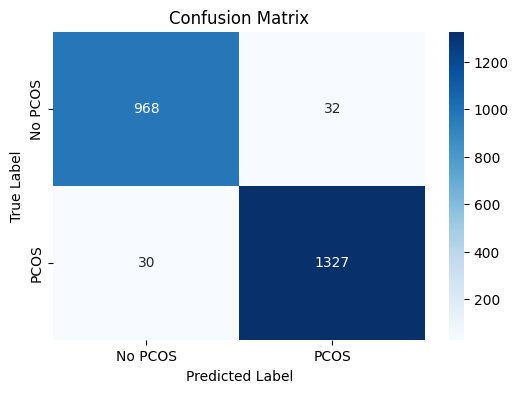


Classification Report:

              precision    recall  f1-score   support

     No PCOS       0.97      0.97      0.97      1000
        PCOS       0.98      0.98      0.98      1357

    accuracy                           0.97      2357
   macro avg       0.97      0.97      0.97      2357
weighted avg       0.97      0.97      0.97      2357



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model on test data
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get prediction probabilities
pred_probs = model2.predict(test_generator)

# Convert probabilities to binary class labels
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# Get true class labels
true_classes = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No PCOS", "PCOS"],
            yticklabels=["No PCOS", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=["No PCOS", "PCOS"]))


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


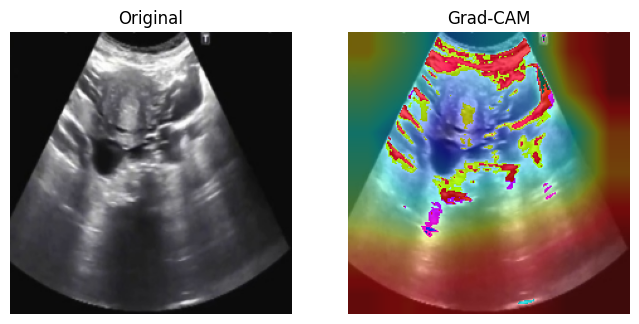

In [24]:
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image

# Load and preprocess image to a numpy array
def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)  # Load image
    array = image.img_to_array(img)                   # Convert to array
    array = np.expand_dims(array, axis=0)             # Add batch dimension
    array = array / 255.0                              # Normalize pixels
    return array, img

# Generate Grad-CAM heatmap for a given image and model
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that outputs activations of last conv layer and model prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # Forward pass
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])         # Predicted class index
        class_channel = predictions[:, pred_index]         # Score for predicted class

    # Compute gradients of class score w.r.t. feature map activations
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pool gradients over width and height
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight feature maps by corresponding gradients and sum
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap values between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on original image and display
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)                            # Read original image
    img = cv2.resize(img, (224, 224))                    # Resize to model input size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap_colored = cm.jet(heatmap_resized)[..., :3] * 255  # Apply colormap
    superimposed_img = heatmap_colored * alpha + img           # Overlay heatmap
    superimposed_img = np.uint8(superimposed_img)              # Convert to uint8

    # Plot original and Grad-CAM images side-by-side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example: pick an image from the PCOS test folder to visualize Grad-CAM
example_path = os.path.join(test_dir, 'pcos', os.listdir(os.path.join(test_dir, 'pcos'))[0])
img_array, original_img = get_img_array(example_path)

# Generate heatmap using last conv layer of your model (MobileNetV2 uses 'Conv_1')
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")

# Display the Grad-CAM overlayed on the original image
display_gradcam(example_path, heatmap)


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model from file
model = tf.keras.models.load_model('C:/Users/ASUS/Downloads/PCOS/pcos_mobilenetv2_model.h5')

# Load and preprocess the input image
img_path = "C:/Users/ASUS/Downloads/PCOS/data/test/normal/Image_SetB976.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
img_array = image.img_to_array(img)                      # Convert to array
img_array = np.expand_dims(img_array, axis=0)            # Add batch dimension
img_array = img_array / 255.0                             # Normalize pixel values

# Predict class probability for the image
prediction = model.predict(img_array)

# Interpret prediction and print label
if prediction[0][0] > 0.5:
    print("Predicted: Abnormal")
else:
    print("Predicted: Normal")

# Print confidence score (probability)
print("Confidence:", prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: Normal
Confidence: 0.1409838
